## This scripts is about the data analysis of main figures in the paper, including some supplementary analyisis. 


In [1]:
import numpy as np
import nilearn
import re
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as img
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import time
import os
import itertools
import argparse
import pandas as pd
import scipy.sparse.linalg 

from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from utils import *
from scipy.stats import ttest_ind, pearsonr, permutation_test, zscore
from statannot import add_stat_annotation
from datetime import date
from plotly.subplots import make_subplots

/Users/enningyang/opt/anaconda3/envs/environmental/lib/python3.8/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


# Data Loading

In [3]:
#pre defined terms
tmp_dir = "/Users/enningyang/Documents/forrest_project/tmp_data" # the folder to store intermediate results
c_names_dict = np.load(f"{tmp_dir}/c_names_dict.npy", allow_pickle=True).item()
yeo7_color = np.load(f"{tmp_dir}/yeo7_color.npy", allow_pickle=True).item() # the seven color used in original paper
haNames = list(np.load(f"{tmp_dir}/hippoAmygNames.npy")) # the names for hippo and amyg subregions
hippoNames = haNames[:19]
amygNames = haNames[19:]
annotations = pickle.load(open(f"{tmp_dir}/annotations.pickle", "rb")) # 52 human curated annotations
annotations_keys = list(annotations.keys())
n_pcs_dict = {'hippo':6, 'amyg':6}
subjects = np.load(f'{tmp_dir}/subjects.pickle',allow_pickle=1) # subject index
save_fig=0 # wether to save model or not
supp = False # supp controls the selection of hmm models, for supp analysis, supp = True
path_to_raw_hmm_models = '/Users/enningyang/Documents/forrest_project'

In [5]:
#gather the wanted models
key = 'final' 
filter_words = [key] # you can add more filters to select the exact set of models. e.g. "subject_01", "Default"
args_list = list(set(np.load(f"{tmp_dir}/hmmlearn_args_list.npy")))

for i in filter_words:
    args_list = filter_args(i, args_list)
if 'final' in args_list[0]:
    if supp:
        args_list = [ i for i in args_list if 'n200_4_states_sub_nmf' in i 
                     or 'n5_4_states_sub_pca' in i 
                     or 'n5_4_states_des_pca' in i 
                     or 'n200_4_states_des_nmf' in i]
    else:
        args_list = [ i for i in args_list if 'n200_4_states_sub_nmf' in i ]     
args_list = np.unique(args_list)
args_list = [i.replace('/home/enning/scratch/forrest',path_to_raw_hmm_models) for i in args_list]

In [8]:
#load the models 
state_p_dict = {} #state presence
cora_dict = {} #correlation with annotations
cort_dict = {} #correlation with semantic components
HMMs_dict = {} #hmm models
for i, a in enumerate(args_list):
    try:
        tmp = get_args(a, 0, return_idx=0)
        state_p_dict[a], cora_dict[a], cort_dict[a], HMMs_dict[
            a], ak, tk, X_stack = tmp
    except Exception as e:
        pass

[Errno 2] No such file or directory: '/Users/enningyang/Documents/forrest_project/hmmlearn/HMMs_final_SomMot_yeo_hippo_3pcs/subject_17_n200_4_states_sub_nmf/sorted_text_score.pickle'


In [9]:
#classify the idx
args_list = list(HMMs_dict.keys())
extra_dict = {
    'hippo': [i for i in args_list if 'hippo' in i],
    'amyg': [i for i in args_list if 'amyg' in i],
}
states = np.unique(np.hstack([re.findall('(\d+)_states',i) for i in args_list]))
region_dict = {key:[i for i in args_list if key in i] for key in yeo7_color.keys()}
states_dict = {key:[i for i in args_list if key in i] for key in states}
sub_dict = {key:[i for i in args_list if 'subject_'+key in i] for key in subjects}
ntext_dict = {key:[i for i in args_list if key in i] for key in ['n200','n5']}

main_research_idx = [i for i in args_list if "n200" in i and "_sub" in i and "nmf" in i]
main_compare = args_list[0] #used for state idx matching
HMM1 = HMMs_dict[main_compare]

# Correlation box plot (Fig 4)

<Figure size 720x576 with 0 Axes>

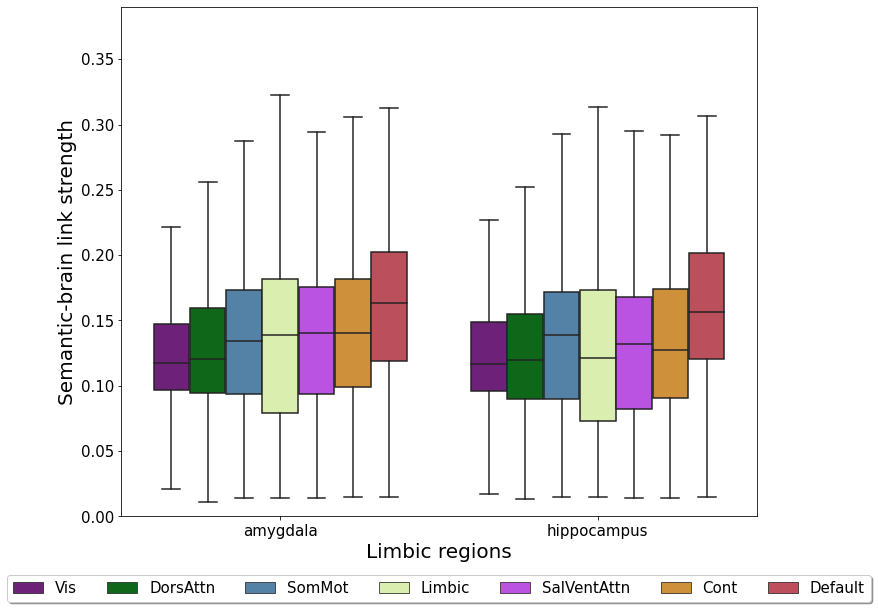

In [6]:
# fig4
import pandas as pd
df_dict = {}
subset = main_research_idx
regions = ["amyg", "hippo"]
net_list = []
cor_list = []
tt_list = []
sub_list = []

for j, region in enumerate(regions):
    extra = region

    target = [i for i in subset if region in i]    
    plt.figure(figsize=(10, 8))
    for i, k in enumerate(target):
        n_text = re.findall("n(\d+)", k)[0]
        text_type = re.findall("states_(\w+)\/", k)[0]+n_text
        if 'pca200' in text_type or 'nmf5' in text_type:
            continue
        tmp = cort_dict[k][2, ...] if cort_dict[k].shape[0] > 2 else cort_dict[k][0, ...]
        if '200' in text_type:
            tmp = np.hstack([np.sort(np.abs(tmp[:,i]),axis=0)[::-1][:10] for i in range(4)])
        else: 
            tmp = np.abs(tmp).flatten()
        size = tmp.shape[0]
        cor_list.append(np.abs(tmp))
        tt_list.append([extra] * size)
        sub = re.findall("subject_(\d\d)", k)[0]
        sub_list.append([sub] * size)
        region = re.findall("(Vis|SomMot|DorsAttn|SalVentAttn|Limbic|Cont|Default|16)", k)[0]
        net_list.append(
            [region] * size)
df = {
    "net": np.hstack(net_list),
    "cor": np.hstack(cor_list),
    "limbic region": np.hstack(tt_list),
    'subject': np.hstack(sub_list)
}
df = pd.DataFrame(df)
df = df.sort_values(["net",'limbic region'])
df_dict[extra+'_'+n_text] = df
df['limbic region'] = df['limbic region'].str.replace('amyg', 'amygdala').replace('hippo', 'hippocampus')
ax = sns.boxplot(x="limbic region",
                    y="cor",
                    hue="net",
                    data=df,
                    palette=yeo7_color,
                    hue_order = df.loc[df['limbic region'] == 'amygdala'].groupby('net').median().sort_values('cor').index.to_numpy(),
                    showfliers = False,
                    )
ax.set_ylim([0,0.39])
plt.yticks(fontsize=15)
plt.xlabel(f"Limbic regions",fontsize=20)
plt.xticks(fontsize=15)
plt.ylabel("Semantic-brain link strength",fontsize=20)
plt.tight_layout()
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=7, fontsize=15)
if save_fig:
    plt.savefig('/Users/enningyang/Downloads/hmm_figs/fig4.png',bbox_inches='tight',dpi=600)

<Figure size 720x432 with 0 Axes>

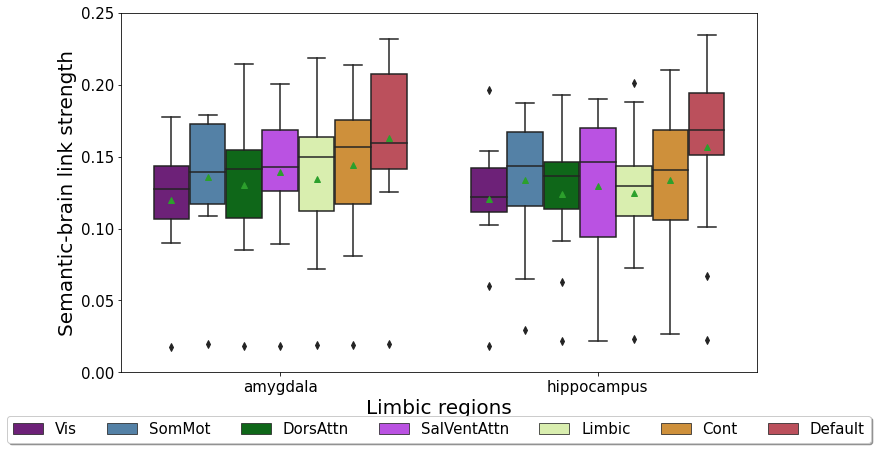

In [13]:
# fig4
import pandas as pd
df_dict = {}
subset = main_research_idx
regions = ["amyg", "hippo"]
net_list = []
cor_list = []
tt_list = []
sub_list = []

for j, region in enumerate(regions):
    extra = region

    target = [i for i in subset if region in i]    
    plt.figure(figsize=(10, 6))
    for i, k in enumerate(target):
        n_text = re.findall("n(\d+)", k)[0]
        text_type = re.findall("states_(\w+)\/", k)[0]+n_text
        if 'pca200' in text_type or 'nmf5' in text_type:
            continue
        tmp = cort_dict[k][2, ...] if cort_dict[k].shape[0] > 2 else cort_dict[k][0, ...]
        if '200' in text_type:
            tmp = np.hstack([np.sort(np.abs(tmp[:,i]),axis=0)[::-1][:10] for i in range(4)])
        else: 
            tmp = np.abs(tmp).flatten()
        size = 1
        cor_list.append(np.mean(np.abs(tmp)))
        tt_list.append([extra] * size)
        sub = re.findall("subject_(\d\d)", k)[0]
        sub_list.append([sub] * size)
        region = re.findall("(Vis|SomMot|DorsAttn|SalVentAttn|Limbic|Cont|Default|16)", k)[0]
        net_list.append(
            [region] * size)
df = {
    "net": np.hstack(net_list),
    "cor": np.hstack(cor_list),
    "limbic region": np.hstack(tt_list),
    'subject': np.hstack(sub_list)
}
df = pd.DataFrame(df)
df = df.sort_values(["net",'limbic region'])
df_dict[extra+'_'+n_text] = df
df['limbic region'] = df['limbic region'].str.replace('amyg', 'amygdala').replace('hippo', 'hippocampus')
ax = sns.boxplot(x="limbic region",
                    y="cor",
                    hue="net",
                    data=df,
                    palette=yeo7_color,
                    hue_order = df.loc[df['limbic region'] == 'amygdala'].groupby('net').median().sort_values('cor').index.to_numpy(),
                    showfliers = True,
                     showmeans=True
                    )
ax.set_ylim([0,0.25])
plt.yticks(fontsize=15)
plt.xlabel(f"Limbic regions",fontsize=20)
plt.xticks(fontsize=15)
plt.ylabel("Semantic-brain link strength",fontsize=20)
plt.tight_layout()
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=7, fontsize=15)

if save_fig:
    plt.savefig('/Users/enningyang/Downloads/hmm_figs/fig4_2.png',bbox_inches='tight',dpi=600)

## Permutation test

In [16]:
n_components, text_type, text_method = re.findall('n(\d+)\S+(\w{3})_(\w{3})\/args.npy', subset[0])[0]
text = pickle.load(open("{}/text_embeddings_n{}_{}_{}.pickle".format(
    tmp_dir, n_components, text_type, text_method), "rb"))[240]
print(text.shape)

(3543, 200)


In [ ]:
import ray
n_perms = 1000
ray.init(num_cpus=10)

@ray.remote
def statistic(x, y):
    cor_sub = []
    for sub in range(x.shape[2]):
        cor = np.zeros((x.shape[1], y.shape[1]))
        for i in range(x.shape[1]):
            for j in range(y.shape[1]):
                cor[i, j] = pearsonr(x[:,i,sub], y[:,j])[0]
        tmp = np.hstack([np.sort(np.abs(cor[:,i]),axis=0)[::-1][:10] for i in range(4)])
        cor_sub.append(np.mean(tmp))
    return np.mean(cor_sub)


for net in yeo7_color.keys():
    for lim in ['amyg', 'hippo']:
        test_set = [i for i in main_research_idx if net in i and lim in i]
        state_p_all = []
        for k in test_set:
            state_p_all.append(state_p_dict[k].T)
        state_p_all = np.array(state_p_all)
        state_p_all = np.transpose(state_p_all, (1, 2, 0))
        perm = []
        for p in range(n_perms):
            np.random.shuffle(state_p_all)
            perm.append(statistic.remote(state_p_all, text))
        res = ray.get(perm)
        print(net + lim)
        np.save(f'{tmp_dir}/perm_res_{net}_{lim}.npy',res)
ray.shutdown()



In [8]:
res_all = {}
for net in yeo7_color.keys():
    for lim in ['amyg', 'hippo']:
        res = np.load(f'{tmp_dir}/perm_res_{net}_{lim}.npy')
        res_all["_".join([net, lim])] = res

Default_amyg


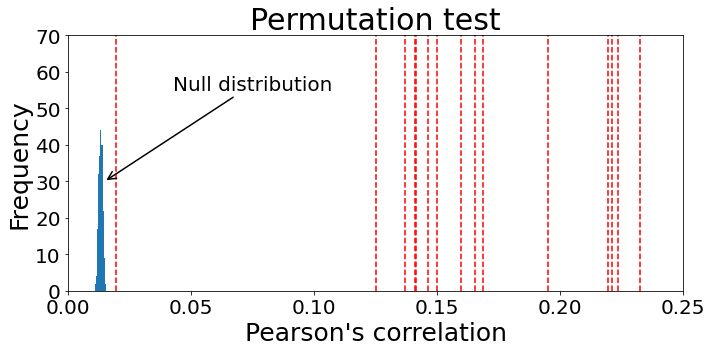

In [48]:
for k,v in res_all.items():
    net, lim = k.split('_')
    truth = df.loc[(df.net == net) & (df['limbic region'].str.contains(lim)),'cor'].to_numpy()
    plt.figure(figsize=(10,5))
    ax = plt.hist(v, bins=50)
    for i in truth:
        plt.axvline(i, ls="--", color="r")
    print(k)
    plt.title(f"Permutation test", fontsize=30)
    plt.xlabel("Pearson's correlation",fontsize=25)
    plt.xlim((0,0.25))
    plt.ylim((0, 70))
    plt.xticks(fontsize=20)
    plt.annotate(
    'Null distribution', xy=(0.015, 30),xytext=(0.075, 55) ,
    horizontalalignment="center",fontsize=20,
    arrowprops=dict(arrowstyle='->',lw=1.5)
    )
    plt.yticks(fontsize=20)
    plt.ylabel("Frequency",fontsize=25)
    plt.tight_layout()
    plt.savefig(f"figs/permutation_test/1000_perm_test_{net} & {lim}.png")
    plt.show()


## Statistical test

In [80]:
df.groupby(['net']).median()

,cor
net,
Cont,0.135251
Default,0.159782
DorsAttn,0.120035
Limbic,0.128739
SalVentAttn,0.136149
SomMot,0.136386
Vis,0.117117


In [81]:
# two pair t test between DN and other networks 
net ='Default'
DN = df.loc[df['net'] == net,'cor'].to_numpy()

t_test_dict = {}
for net in np.unique(df.net):
    if net == 'Default':
        continue
    test = df.loc[df['net'] == net,'cor'].to_numpy()
    t_test_dict[net] = ttest_ind(DN, test, alternative='greater')[1]
t_test_dict

## sup fig, additional validation sets

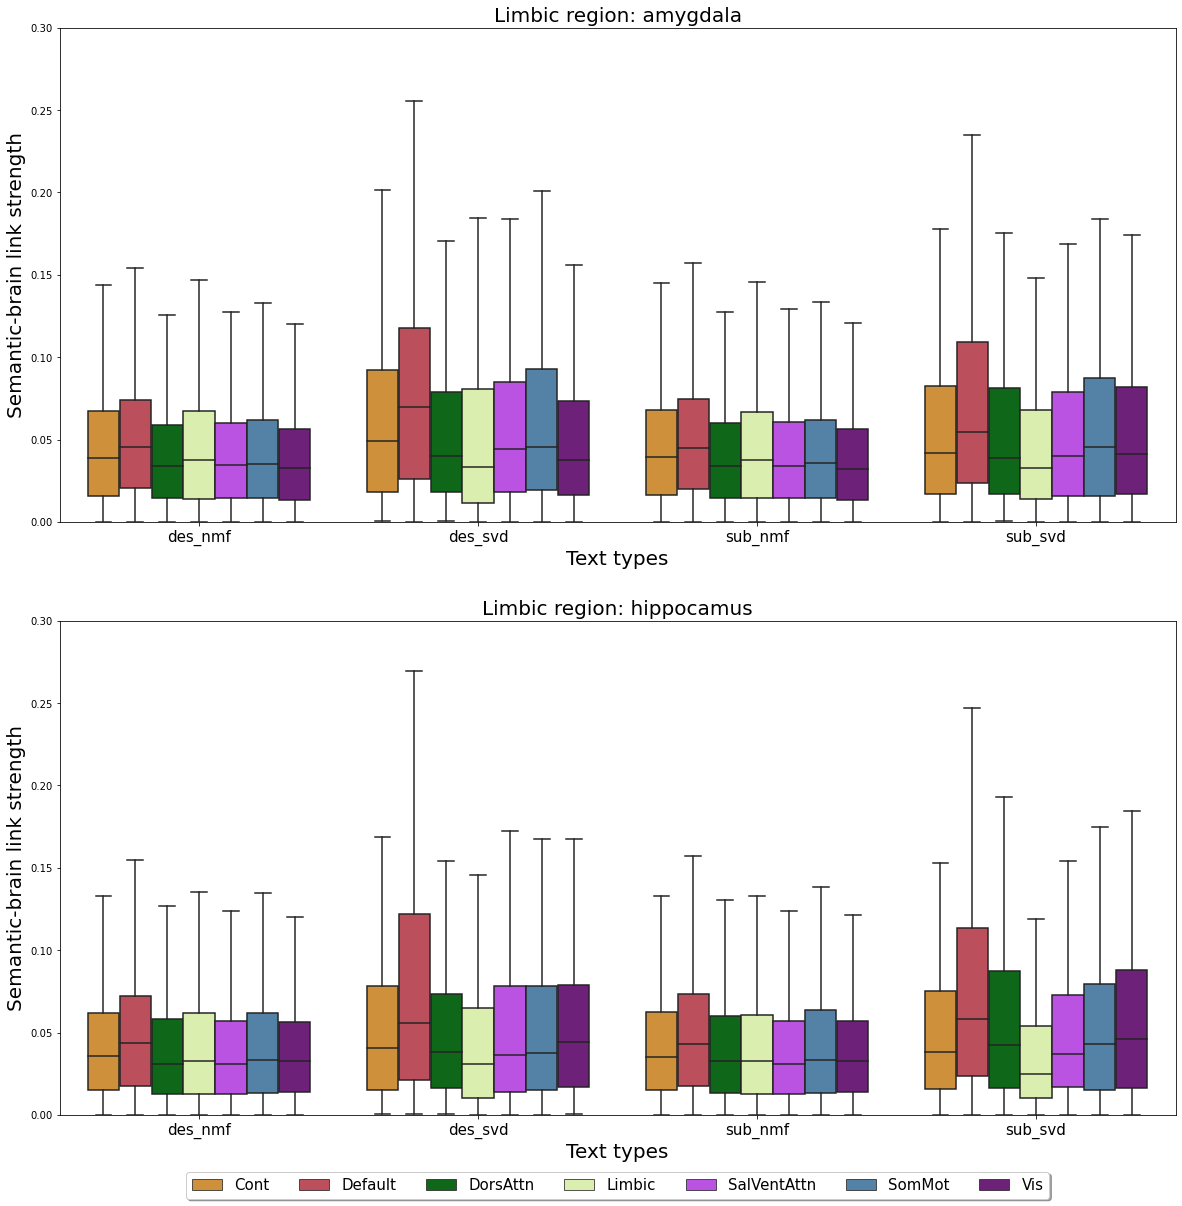

<Figure size 1080x1008 with 0 Axes>

<Figure size 1080x1008 with 0 Axes>

In [57]:
regions = ["amyg", "hippo"]
fig, axs = plt.subplots(ncols=1, nrows=2, figsize=(20, 20))
for j, region in enumerate(regions):
    target = [i for i in args_list if region in i]
    net_list = []
    cor_list = []
    tt_list = []
    plt.figure(figsize=(15, 14))
    for i, k in enumerate(target):
        tmp = cort_dict[k][2, ...].flatten() if cort_dict[k].shape[0] > 2 else cort_dict[k][0, ...].flatten()
        size = tmp.shape[0]
        cor_list.append(np.abs(tmp))
        region = re.findall("(Vis|SomMot|DorsAttn|SalVentAttn|Limbic|Cont|Default|16)", k)[0]
        net_list.append(
            [region] * size)
        tt_list.append([re.findall("states_(\w+)\/", k)[0].replace('pca', 'svd')] * size)
    df = {
        "net": np.hstack(net_list),
        "cor": np.hstack(cor_list),
        "text_type": np.hstack(tt_list)
    }
    df = pd.DataFrame(df)
    df = df.sort_values(["net",'text_type'])
    bplot = sns.boxplot(x="text_type",
                        y="cor",
                        hue="net",
                        data=df,
                        palette=yeo7_color,
                        showfliers = False,
                        ax=axs[j])
    axs[j].set_ylim([0,0.3])
    if i == 0:
        axs[i, j].set_title(f"Extra: {regions[j]}", size="x-large")
axs[0].set_ylabel("Semantic-brain link strength",fontsize=20)
axs[1].set_ylabel("Semantic-brain link strength",fontsize=20)
axs[0].set_xlabel("Text types",fontsize=20)
axs[1].set_xlabel("Text types",fontsize=20)
axs[0].set_xticklabels(np.unique(df['text_type']),fontsize=15)
axs[1].set_xticklabels(np.unique(df['text_type']),fontsize=15)
# axs[2,0].set_ylabel("combine",size="x-large")
axs[0].set_title("Limbic region: amygdala",fontsize=20)
axs[1].set_title("Limbic region: hippocamus",fontsize=20)
axs[0].legend([],[], frameon=False)
axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=7, fontsize=15)
plt.tight_layout()
if save_fig:
    plt.savefig("figs/text_correlation/yeo7_cor_text_4states.png")

# How does different subject align with each other (Fig5)


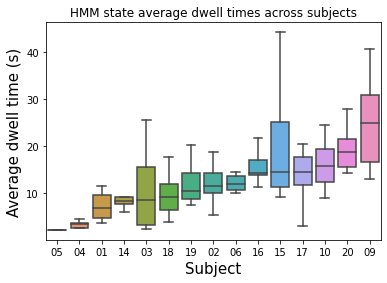

In [27]:
# dwell time across subjects. Fig 5A
subset = main_research_idx
main_compare = subset[0]
HMM1 = HMMs_dict[main_compare]
add_pcs = 1
rst = []
keys = []
for k in subset:
    state_p = state_p_dict[k]
    dom_list = []
    for i in range(3543):
        dom = np.argmax(state_p[:, i])
        dom_list.append(dom)
    key = re.findall('[A-Z]\w+|hippo|amyg',k)
    tmp =[np.round(np.mean(cal_len(dom_list, i)),3) for i in range(4)]
    key = re.findall('_([A-Z][a-z]+)',k)[0] + '_' +re.findall('hippo|amyg',k)[0]

    keys.append(key)
    rst.append(tmp)
df = pd.DataFrame({'key':keys, 'dwell_time':rst})

subset = main_research_idx
main_compare = subset[0]
HMM1 = HMMs_dict[main_compare]
add_pcs = 1
rst = []
keys = []
subject_fo = []
for k in subset:
    state_p = state_p_dict[k]
    dom_list = []
    for i in range(3543):
        dom = np.argmax(state_p[:, i])
        dom_list.append(dom)
    key = re.findall('[A-Z]\w+|hippo|amyg',k)
    tmp = 2*np.mean(np.hstack([cal_len(dom_list, i) for i in range(4)]))
    fo = np.hstack([sum(cal_len(dom_list, i))/3543 for i in range(4)])
    subject_fo.append(fo)
    key = re.findall('subject_\d\d', k)[0].replace('ject','')
    keys.append(key)
    rst.append(tmp)
subject_fo = np.array(subject_fo)

df = pd.DataFrame({'key':keys, 'dwell_time':rst, 'fo_s1':subject_fo[:,0], 'fo_s2':subject_fo[:,1], 
                   'fo_s3':subject_fo[:,2], 'fo_s4':subject_fo[:,3]})
df.key = df.key.str.replace('sub_','')
sns.boxplot(x='key', y='dwell_time',data=df, order= df.groupby('key').median().sort_values('dwell_time').index,showfliers = False)
plt.xticks(rotation='0',ha='center')
plt.ylabel('Average dwell time (s)',fontsize=15)
plt.xlabel('Subject',fontsize=15)
plt.title('HMM state average dwell times across subjects')
if save_fig:
    plt.savefig('/Users/enningyang/Downloads/hmm_figs/fig4a.png', dpi=600)

In [28]:
df.groupby('key').std()
subject_fo_df = df.groupby('key').median()
subject_fo_df.head()

,dwell_time,fo_s1,fo_s2,fo_s3,fo_s4
key,,,,,
01,6.812958,0.248236,0.214931,0.285493,0.216342
02,11.628894,0.246401,0.258256,0.236664,0.257550
03,8.695896,0.253175,0.291420,0.208721,0.194327
04,3.559192,0.259526,0.174005,0.255715,0.214084
05,2.275530,0.247954,0.266582,0.258115,0.255433


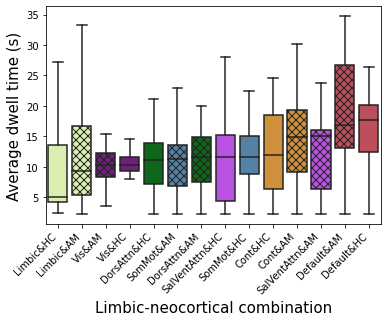

In [29]:
# dwell time across region-network combos. Fig 5B

subset = main_research_idx
main_compare = subset[0]
HMM1 = HMMs_dict[main_compare]
add_pcs = 1
rst = []
keys = []
for k in subset:
    state_p = state_p_dict[k]
    dom_list = []
    for i in range(3543):
        dom = np.argmax(state_p[:, i])
        dom_list.append(dom)
    key = re.findall('[A-Z]\w+|hippo|amyg',k)
    tmp = 2*np.mean(np.hstack([cal_len(dom_list, i) for i in range(4)]))
    key = re.findall('_([A-Z]\w+)_yeo',k)[0] + '_' +re.findall('hippo|amyg',k)[0].replace('hippo','HC').replace('amyg','AM')
    keys.append(key)
    rst.append(tmp)

df = pd.DataFrame({'key': keys, 'dwell_time': rst})
df.key = df.key.str.replace('_','&')
limbic = [i.split('&')[1] for i in df.groupby('key').median().sort_values('dwell_time').index]
a= {i+'&HC':j for i,j in yeo7_color.items()}
a.update({i+'&AM':j for i,j in yeo7_color.items()})

ax = sns.boxplot(
    x='key',
    y='dwell_time',
    data=df,
    palette=a,
    order=df.groupby('key').median().sort_values('dwell_time').index,showfliers = False)
# Define some hatches
limbic = [i.split('&')[1] for i in df.groupby('key').median().sort_values('dwell_time').index]
# Loop over the bars
plt.xticks(rotation='45',ha='right')
plt.ylabel('Average dwell time (s)',fontsize=15)
plt.xlabel('Limbic-neocortical combination',fontsize=15)
# plt.title(
#     'HMM state average dwell times across region-network combinations (concat, 1 average)'
# )
for i,thisbar in enumerate(ax.artists):
    # Set a different hatch for each bar
    if limbic[i] != 'HC':
        thisbar.set_hatch('xxx')

if save_fig:
    plt.savefig('/Users/enningyang/Downloads/hmm_figs/fig4b.png', dpi=600,bbox_inches='tight')

In [30]:
# table level data
df.groupby('key').std()
pd.set_option("display.precision", 2)
subject_fo_df['median'] = df.groupby('key').median()
subject_fo_df['std'] = df.groupby('key').std()
rst = subject_fo_df.iloc[:,1:]
rst.to_excel("/Users/enningyang/Downloads/hmm_figs/sup_table1.xlsx")

## Statistical tests: pairwise compairsion t-test across different region-network combos


In [32]:
# pairwise compairsion t-test
for i in yeo7_color.keys():
    for j in yeo7_color.keys():
        if i==j:
            continue
        d1 = df.loc[df['key'].str.contains(i), 'dwell_time'].to_numpy()
        d2 = df.loc[df['key'].str.contains(j), 'dwell_time'].to_numpy()
        alt = "greater" if np.mean(d1) > np.mean(d2) else 'less'
        p_val= ttest_ind(d1, d2, alternative=alt)[1]
        if p_val <= 0.05:
            print(i,j)
            print(np.mean(d1), np.mean(d2), p_val)

Vis Cont
9.93048219547079 14.437109325414388 0.005503933374784169
Vis Default
9.93048219547079 17.57005494699773 4.1586162771339374e-05
SomMot Cont
11.13580872617555 14.437109325414388 0.04816661812451741
SomMot Default
11.13580872617555 17.57005494699773 0.0012726309838822973
DorsAttn Cont
11.086256441626576 14.437109325414388 0.04662036465641813
DorsAttn Default
11.086256441626576 17.57005494699773 0.0012179618876844405
SalVentAttn Default
11.851965409609488 17.57005494699773 0.004223341386952161
Cont Vis
14.437109325414388 9.93048219547079 0.005503933374784169
Cont SomMot
14.437109325414388 11.13580872617555 0.04816661812451741
Cont DorsAttn
14.437109325414388 11.086256441626576 0.04662036465641813
Default Vis
17.57005494699773 9.93048219547079 4.1586162771339374e-05
Default SomMot
17.57005494699773 11.13580872617555 0.0012726309838822973
Default DorsAttn
17.57005494699773 11.086256441626576 0.0012179618876844405
Default SalVentAttn
17.57005494699773 11.851965409609488 0.00422334138

In [33]:
# AM vs HC
for i in yeo7_color.keys():
    k1 = i + '&HC'
    k2 = i + '&AM'
    d1 = df.loc[df['key'] == k1, 'dwell_time'].to_numpy()
    d2 = df.loc[df['key'] == k2, 'dwell_time'].to_numpy()
    alt = "greater" if np.mean(d1) > np.mean(d2) else 'less'
    p_val= ttest_ind(d1, d2, alternative=alt)[1]
    if p_val <= 0.05:
        print(i,j)
        print(np.mean(d1), np.mean(d2), p_val)

In [34]:
df.groupby('key').mean().sort_values('dwell_time')

,dwell_time
key,
Vis&AM,9.91
Vis&HC,9.95
DorsAttn&HC,10.47
SomMot&AM,10.83
SalVentAttn&HC,11.41
SomMot&HC,11.44
DorsAttn&AM,11.66
SalVentAttn&AM,12.29
Limbic&HC,12.34


In [35]:
# Default&HC vs rest
net ='Default&HC'
DN = df.loc[df['key'] == net,'dwell_time'].to_numpy()

t_test_dict = {}
for net in np.unique(df.key):
    if net == 'Default&HC':
        continue
    test = df.loc[df['key'] == net,'dwell_time'].to_numpy()
    t_test_dict[net] = ttest_ind(DN, test,alternative='greater')[1]

In [36]:
t_test_dict

{'Cont&AM': 0.2832923692572782,
 'Cont&HC': 0.22568429174909527,
 'Default&AM': 0.7104453272490872,
 'DorsAttn&AM': 0.047631054022007194,
 'DorsAttn&HC': 0.016113112228226478,
 'Limbic&AM': 0.208314253973079,
 'Limbic&HC': 0.1618086431603264,
 'SalVentAttn&AM': 0.06637739050609145,
 'SalVentAttn&HC': 0.045699136507049286,
 'SomMot&AM': 0.023244782719144444,
 'SomMot&HC': 0.037838655554881806,
 'Vis&AM': 0.005317738004637862,
 'Vis&HC': 0.005380412327752944}

In [37]:
df.groupby('key').median().sort_values('dwell_time')

,dwell_time
key,
Limbic&HC,5.09
Limbic&AM,9.29
Vis&AM,10.21
Vis&HC,10.28
DorsAttn&HC,11.12
SomMot&AM,11.21
DorsAttn&AM,11.58
SalVentAttn&HC,11.62
SomMot&HC,11.62


# Fig6: group level signatures (PLS-R) 

In [49]:
# load data
hippo_dict = pickle.load(open(f"{tmp_dir}/hippo_timeseries_{3}pcs_dict.pickle","rb"))
hippo_data = np.array(np.vstack([i for i in hippo_dict.values()]))
amyg_dict = pickle.load(open(f"{tmp_dir}/amyg_timeseries_{3}pcs_dict.pickle","rb"))
amyg_data = np.array(np.vstack([i for i in amyg_dict.values()]))
fig6_subset = [i for i in args_list if 'Default' in i and 'sub_nmf' in i and 'n200' in i]
main_compare = fig6_subset[0]
HMM1 = HMMs_dict[main_compare]

In [50]:
# aggregate brain imaging data
data_dict = pickle.load(open(f"{tmp_dir}/schaefer_timeseries_dict_z_scored.pickle", "rb"))
concat_data = np.array(np.vstack([i for i in data_dict.values()]))
schaefer = nilearn.datasets.fetch_atlas_schaefer_2018(100)
region = 'Default'
labels_strings = []
for label in schaefer.labels:
    labels_strings.append(label.decode('utf-8'))
xticks = [
    i.replace('7Networks_', '') for i in labels_strings if region in i
]

dmn_idx =  [i for i, s in enumerate(labels_strings) if region in s]
region_idx = [i for i, s in enumerate(labels_strings) if 'Vis' in s]

dmn_data = zscore(concat_data[:,dmn_idx])
dmn_data.shape

(53145, 24)

In [51]:
# aggregate label data
n_components, text_type, text_method = re.findall('n(\d+)\S+(\w{3})_(\w{3})\/args.npy', fig6_subset[0])[0]
model = PLSRegression(n_components=1)
text = pickle.load(open("{}/text_embeddings_n{}_{}_{}.pickle".format(
    tmp_dir, n_components, text_type, text_method), "rb"))[240]
annotations_data = np.vstack([v for v in annotations.values()]).T
labels_sing = np.hstack([text, annotations_data])
labels = zscore(np.vstack([labels_sing for i in range(15)]))
labels.shape

(53145, 252)

In [52]:
# pearsonr before semantic dissection pairings
x,y = model.fit_transform(labels,dmn_data)

x = x.reshape((-1))
y = y.reshape((-1))

pearsonr(x, y)

/Users/enningyang/opt/anaconda3/envs/environmental/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:108: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


PearsonRResult(statistic=5.204170427930421e-18, pvalue=0.9999999999323482)

## Hippo

In [68]:
extra = 'hippo'
subset = [i for i in args_list if extra in i and 'Default' in i and 'sub_nmf' in i and 'n200' in i]
HMM1 = HMMs_dict[subset[0]]
state_idx = []
extra_dict = hippo_dict if extra == 'hippo' else amyg_dict
main_compare = subset[0]
for k in subset:
    v = state_p_dict[k]
    if k != main_compare:
        idx = sort_state(HMM1, HMMs_dict[k])
        v = v[idx,:]
    v_s = np.argmax(v,axis=0) + 1
    state_idx.append([np.where(v_s==i)[0] for i in range(1,5)])
dmn_data = {}
sub_bound = {}
for state in range(1,5):
    concat = []
    limbic = []
    bound = []
    for i in range(15):
        concat.append(data_dict[subjects[i]][state_idx[i][state-1],:])
        if len(bound) != 0:
            bound.append(len(state_idx[i][state-1])+bound[-1])
        else:
            bound.append(len(state_idx[i][state-1]))
        pca = np.load(f'{tmp_dir}/hippo_pca_{subjects[i]}.npy', allow_pickle=True).item()
        left = pca.inverse_transform(extra_dict[subjects[i]][state_idx[i][state-1],:][:,:3])
        right = pca.inverse_transform(extra_dict[subjects[i]][state_idx[i][state-1],:][:,3:6])
        tmp = np.hstack([left,right])
        limbic.append(tmp)

    rst = np.hstack([np.vstack(concat)[:, region_idx], np.vstack(limbic)])
    dmn_data[state] = rst
    sub_bound[state] = bound
label_data = {}
for state in range(1,5):
    concat = []
    for i in range(15):
        concat.append(labels_sing[state_idx[i][state-1],:])
    label_data[state] = np.vstack(concat)

/Users/enningyang/opt/anaconda3/envs/environmental/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [69]:
x_loadings = []
y_loadings = []
coef = []
for state in range(1,5):
    x,y = model.fit_transform(label_data[state],dmn_data[state])
    x_loadings.append(model.x_loadings_)
    y_loadings.append(model.y_loadings_)
    x = x.reshape((-1))
    y = y.reshape((-1))
    coef.append(model.coef_)
    print("state", state, pearsonr(x, y))

state 1 PearsonRResult(statistic=0.13211405325113046, pvalue=3.60105725613897e-53)
state 2 PearsonRResult(statistic=0.14573710216530342, pvalue=1.699916900902529e-56)
state 3 PearsonRResult(statistic=0.1400123917765527, pvalue=8.885165565966758e-60)
state 4 PearsonRResult(statistic=0.12256573845112564, pvalue=4.042108253436183e-50)


/Users/enningyang/opt/anaconda3/envs/environmental/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


In [70]:
# cross validation of the pearson correlation 
from sklearn.model_selection import KFold

model = PLSRegression(n_components=1)
cvs = []
print(f"limbic data: {extra}")
for k in [20]:
    for state in range(1,5):
        x,y = model.fit_transform(label_data[state],dmn_data[state])
        x_loadings.append(model.x_loadings_)
        y_loadings.append(model.y_loadings_)
        x = x.reshape((-1))
        y = y.reshape((-1))
        kf = KFold(n_splits=k)
        cv_r = []
        for j in range(k):
            train = []
            test = []
            for i in range(15):
                pre = sub_bound[state][i-1] if i != 0 else 0
                post = sub_bound[state][i]
                train_sub, test_sub = list(kf.split(range(pre, post)))[j]
                train.append(train_sub)
                test.append(test_sub)
            train = np.hstack(train)
            test = np.hstack(test)
            model.fit(label_data[state][train],dmn_data[state][train])
            x_embed, y_embed = model.transform(label_data[state][test], dmn_data[state][test])
            x_embed = x_embed.reshape((-1))
            y_embed = y_embed.reshape((-1))
            cv_r.append(pearsonr(x_embed, y_embed)[0])
        cvs.append(cv_r)
        print(f"state {state}'s {k} fold cv pearson's r", np.round(np.mean(cv_r),4), '+-',  np.round(np.std(cv_r),4))

df_cv_hippo = pd.DataFrame({"Limbic":['Hippocampus']*k*4, 
                            'state':np.hstack([[str(i+1)]*k for i in range(4)]), 
                            'rho': np.hstack(cvs)})

limbic data: hippo
state 1's 20 fold cv pearson's r 0.3475 +- 0.143
state 2's 20 fold cv pearson's r 0.4557 +- 0.1376
state 3's 20 fold cv pearson's r 0.2696 +- 0.1125
state 4's 20 fold cv pearson's r 0.2814 +- 0.1422


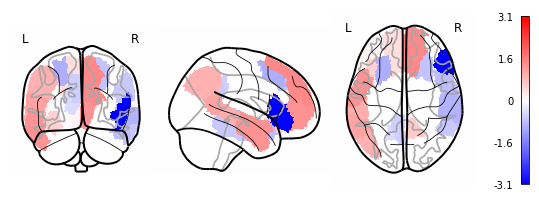

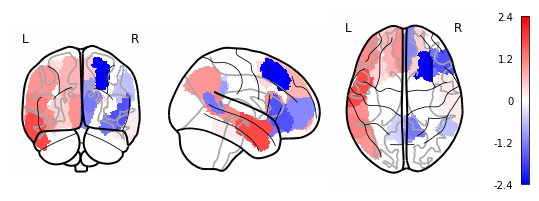

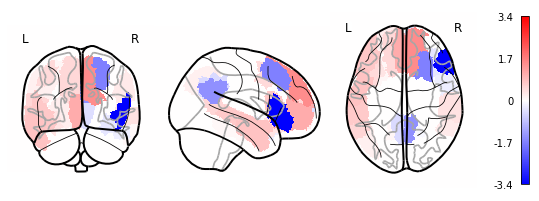

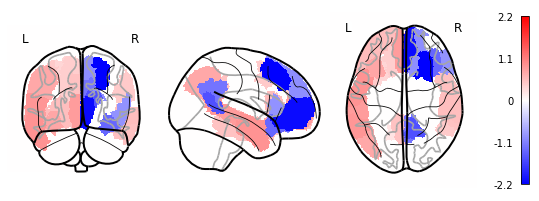

In [205]:
# brain plots
raw_brain = []
for i in range(4):
    schaefer = nilearn.datasets.fetch_atlas_schaefer_2018(n_rois=100,
                                                yeo_networks=7)
    schaefer_rois = np.array(schaefer.labels, dtype=str)
    schaefer_atlas = schaefer.maps
    masker = NiftiLabelsMasker(labels_img=schaefer_atlas, standardize=False,
                                    memory='nilearn_cache').fit()
    data = np.zeros(100)
    data[dmn_idx] = zscore(y_loadings[i][:24]).reshape((-1))
    data = np.reshape(data, (-1, 1))
    nifti = masker.inverse_transform(data.T)
    raw_brain.append(nifti)
    plotting.plot_glass_brain(nifti, threshold=None, colorbar=True,
                                  plot_abs=False, black_bg=False, cmap='bwr',
                                  symmetric_cbar=True, alpha=1)
#     plt.show()

Text(32.09374999999999, 0.5, 'hippocampal subregion')

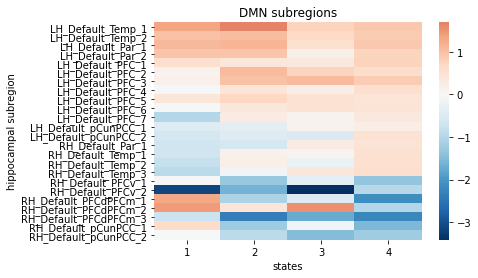

In [204]:
# heatmap of brain plots
xticks = get_xticks(k)[:24]
dmn = []
for i in range(4):
    dmn.append(zscore(y_loadings[i][:24]))
dmn = np.hstack(dmn)

sns.heatmap(dmn, cmap='RdBu_r', center=0, yticklabels=xticks, xticklabels=range(1, 5))
plt.title('DMN subregions')
plt.xlabel('states')
plt.ylabel('hippocampal subregion')

Text(32.09374999999999, 0.5, 'hippocampal subregion')

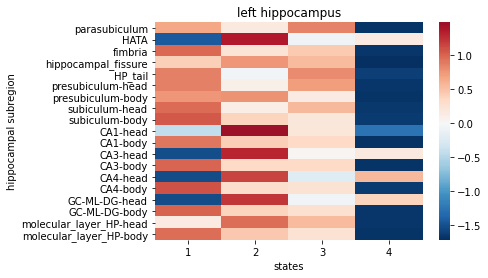

In [206]:
# heatmap of limbic subregions
extra_loadings = zscore(np.array(y_loadings)[...,0][:,17:])
haNames = list(np.load(f'{tmp_dir}/hippoAmygNames.npy'))
hippoNames = haNames[:19]
sns.heatmap(extra_loadings[:,:19].T, cmap='RdBu_r', center=0, yticklabels=hippoNames, xticklabels=range(1, 5))
plt.title('left hippocampus')
plt.xlabel('states')
plt.ylabel('hippocampal subregion')

Text(32.09374999999999, 0.5, 'hippocampal subregion')

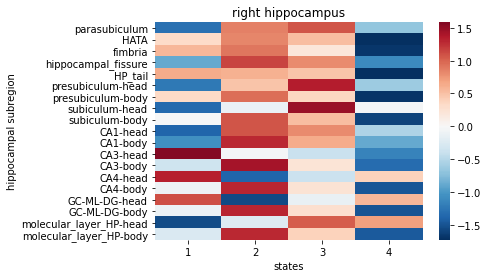

In [207]:
# heatmap of limbic subregions

haNames = list(np.load(f'{tmp_dir}/hippoAmygNames.npy'))
hippoNames = haNames[:19]
sns.heatmap(extra_loadings[:,19:].T, cmap='RdBu_r', center=0, yticklabels=hippoNames, xticklabels=range(1, 5))
plt.title('right hippocampus')
plt.xlabel('states')
plt.ylabel('hippocampal subregion')

In [208]:
hippoName_short = np.load(f'{tmp_dir}/hippoNames_short.npy')
hippoName_short = ['Para', 'HATA', 'Fimbria', 'Fissure', 'HP tail', 'PrS head',
       'PrS body', 'Sub head', 'Sub body', 'CA1 head', 'CA1 body', 'CA3 head', 'CA3 body', 'CA4 head',
       'CA4 body', 'DG head', 'DG body', 'ML head', 'ML body']
np.save(f'{tmp_dir}/hippoNames_short.npy',hippoName_short)


In [210]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import pandas as pd
left_data = extra_loadings[:,:19]
right_data = extra_loadings[:,19:]
hippoName_short = np.load(f'{tmp_dir}/hippoNames_short.npy')
tight = go.layout.Margin(
        l=0, #left margin
        r=0, #right margin
        b=0, #bottom margin
        t=0, #top margin
    )
categories = hippoName_short
layout = go.Layout(
  margin=go.layout.Margin(
        l=0, #left margin
        r=0, #right margin
        b=0, #bottom margin
        t=0, #top margin
    )
)
fig = make_subplots(rows=4, cols=2,specs=[[{'type': 'polar'}]*2]*4,
                    row_titles=['State1','State2', 'State3','State4'],horizontal_spacing =0.1,
                    vertical_spacing = 0.05)

for i in range(4):
    fig.add_trace(go.Scatterpolar(
          r=left_data[i].clip(min=0),
          theta=categories,
          fill='toself',fillcolor='orangered',line_color='red',dr=0.5,
          name='Pos',showlegend=not(i),opacity=0.7
    ),row=i+1,col=1)
    fig.add_trace(go.Scatterpolar(
          r=np.abs(left_data[i].clip(max=0)),
          theta=categories,
          fill='toself',fillcolor='lightblue',line_color='blue',dr=0.5,
          name='Neg',showlegend=not(i),opacity=0.7

    ),row=i+1,col=1)

    fig.add_trace(go.Scatterpolar(
          r=right_data[i].clip(min=0),
          theta=categories,
          fill='toself',fillcolor='orangered',line_color='red',dr=0.5,
          name='Pos',showlegend=False,opacity=0.7

    ),    row=i+1,col=2)
    fig.add_trace(go.Scatterpolar(
          r=np.abs(right_data[i].clip(max=0)),
          theta=categories,
          fill='toself',fillcolor='lightblue',line_color='blue',dr=0.5,
          name='Neg',showlegend=False,opacity=0.7
            ),row=i+1,col=2)


fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
    )),
  showlegend=True,
height=1200, width=800, margin=go.layout.Margin(
        l=25, #left margin
        r=10, #right margin
        b=30, #bottom margin
        t=100, #top margin
    ),title='Contribution of Each Subregion',title_x=0.5
    

)

In [225]:
label_loading = np.array(x_loadings)[...,0]
x = np.array(x_loadings)[...,0]
emotion_idx = np.array(list(range(210,223)))
place_idx = np.array(range(223,244))
other_idx = np.hstack([list(range(200,210)),list(range(244,252))])
an_max = []
max_data = []
for i in [emotion_idx,place_idx,other_idx]:
    subset = np.array(annotations_keys)[i-200]
    subset_data = x[:,i]
    an_max.append([subset[k] for k in np.argmax((x[:,i]),axis=1)])
    max_data.append([subset_data[j,k] for j,k in enumerate(np.argmax((x[:,i]),axis=1))])

an_max = np.array(an_max)
max_data = np.vstack(max_data)

180 0.22062502804573625
103 0.30292268331908223
22 0.2526186716495508
185 0.19973302456067538


/Users/enningyang/opt/anaconda3/envs/environmental/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/Users/enningyang/opt/anaconda3/envs/environmental/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/Users/enningyang/opt/anaconda3/envs/environmental/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will r

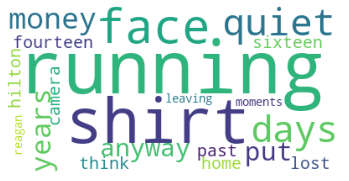

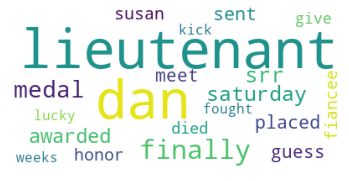

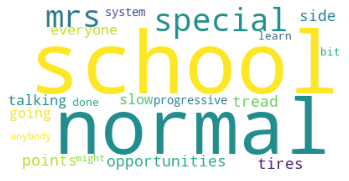

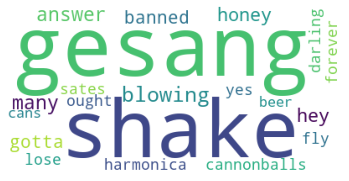

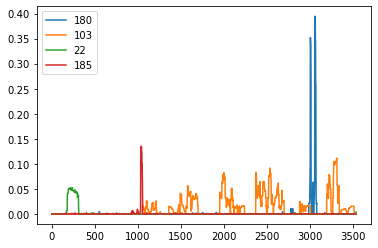

In [219]:
lsa_embed = np.load(f'{tmp_dir}/lsa_embed_sub_nmf200.npy')

max_t = np.argmax(x[:,:200],axis=1)
for j, i in enumerate(max_t):
    plt.figure()
    print(i, x[j,i])
    image = img.imread("figs/text_components/{}of{}_{}_nmf.png".format(i, n_components, 'sub'))
    plt.axis('off')
    plt.imshow(image)
plt.figure()
for i in max_t:
    sns.lineplot(range(3543), lsa_embed[:,i], label=i)

In [223]:
import plotly.figure_factory as ff

z = max_data.T[::-1,:]

xx = ['Emotion', 'Places', 'Others']
yy = ['State1', 'State2', 'State3','State4']
yy = yy[::-1]
z_text = an_max.T[::-1,:]
z_text = np.where(z_text == 'Greenbow Alabama', 'Greenbow', z_text)

fig = ff.create_annotated_heatmap(z, x=xx, y=yy, annotation_text=z_text, colorscale='viridis',showscale=True)
fig.update_layout(
    autosize=False,
    width=700,
    height=1000,
    font=dict(
        size=20
    )
#     paper_bgcolor="LightSteelBlue",
)
fig.update_traces(colorbar={'len':0.5})
fig.update_traces(colorbar_tickfont={'size':15})
for i in range(len(fig.layout.annotations)):
    fig.layout.annotations[i].font.size = 19
fig.show()

## Amyg

In [74]:
extra = 'amyg'
subset = [i for i in args_list if extra in i and 'Default' in i and 'sub_nmf' in i and 'n200' in i]
HMM1 = HMMs_dict[subset[0]]
state_idx = []
extra_dict = hippo_dict if extra == 'hippo' else amyg_dict
main_compare = subset[0]
for k in subset:
    v = state_p_dict[k]
    if k != main_compare:
        idx = sort_state(HMM1, HMMs_dict[k])
        v = v[idx,:]
    v_s = np.argmax(v,axis=0) + 1
    state_idx.append([np.where(v_s==i)[0] for i in range(1,5)])
dmn_data = {}
sub_bound = {}
for state in range(1,5):
    concat = []
    limbic = []
    bound = []
    for i in range(15):
        concat.append(data_dict[subjects[i]][state_idx[i][state-1],:])
        if len(bound) != 0:
            bound.append(len(state_idx[i][state-1])+bound[-1])
        else:
            bound.append(len(state_idx[i][state-1]))
        pca = np.load(f'{tmp_dir}/amyg_pca_{subjects[i]}.npy', allow_pickle=True).item()
        left = pca.inverse_transform(extra_dict[subjects[i]][state_idx[i][state-1],:][:,:3])
        right = pca.inverse_transform(extra_dict[subjects[i]][state_idx[i][state-1],:][:,3:6])
        tmp = np.hstack([left,right])
        limbic.append(tmp)

    rst = np.hstack([np.vstack(concat)[:, dmn_idx], np.vstack(limbic)])
    dmn_data[state] = rst
    sub_bound[state] = bound
label_data = {}
for state in range(1,5):
    concat = []
    for i in range(15):
        concat.append(labels_sing[state_idx[i][state-1],:])
    label_data[state] = np.vstack(concat)

/Users/enningyang/opt/anaconda3/envs/environmental/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [75]:
x_loadings = []
y_loadings = []
coef = []
for state in range(1,5):
    x,y = model.fit_transform(label_data[state],dmn_data[state])
    x_loadings.append(model.x_loadings_)
    y_loadings.append(model.y_loadings_)
    x = x.reshape((-1))
    y = y.reshape((-1))
    coef.append(model.coef_)
    print("state", state, pearsonr(x, y))

state 1 PearsonRResult(statistic=0.1253404636486919, pvalue=4.742382672881159e-50)
state 2 PearsonRResult(statistic=0.14392151347802243, pvalue=1.280445595917859e-57)
state 3 PearsonRResult(statistic=0.12276247243502432, pvalue=1.5314062905202838e-44)
state 4 PearsonRResult(statistic=0.1452386144084775, pvalue=5.67486036165893e-67)


/Users/enningyang/opt/anaconda3/envs/environmental/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


In [76]:
# cross validation of the pearson correlation 
from sklearn.model_selection import KFold

model = PLSRegression(n_components=1)
print(f"limbic data: {extra}")
cvs = []
for k in [20]:
    for state in range(1, 5):
        x,y = model.fit_transform(label_data[state], dmn_data[state])
        x_loadings.append(model.x_loadings_)
        y_loadings.append(model.y_loadings_)
        x = x.reshape((-1))
        y = y.reshape((-1))
        kf = KFold(n_splits=k)
        cv_r = []
        for j in range(k):
            train = []
            test = []
            for i in range(15):
                pre = sub_bound[state][i-1] if i != 0 else 0
                post = sub_bound[state][i]
                train_sub, test_sub = list(kf.split(range(pre, post)))[j]
                train.append(train_sub)
                test.append(test_sub)
            train = np.hstack(train)
            test = np.hstack(test)
            model.fit(label_data[state][train],dmn_data[state][train])
            x_embed, y_embed = model.transform(label_data[state][test], dmn_data[state][test])
            x_embed = x_embed.reshape((-1))
            y_embed = y_embed.reshape((-1))
            cv_r.append(pearsonr(x_embed, y_embed)[0])
        cvs.append(cv_r)
        print(f"state {state}'s {k} fold cv pearson's r", np.round(np.mean(cv_r), 4), '+-', np.round(np.std(cv_r), 4))


limbic data: amyg
state 1's 20 fold cv pearson's r 0.443 +- 0.2424
state 2's 20 fold cv pearson's r 0.4197 +- 0.2153
state 3's 20 fold cv pearson's r 0.4485 +- 0.0682
state 4's 20 fold cv pearson's r 0.3298 +- 0.0949


In [81]:
df_cv_amyg = pd.DataFrame({"Limbic":['Amygdala']*k*4, 
                      'state':np.hstack([[str(i+1)]*k for i in range(4)]), 
                      'rho': np.hstack(cvs)})

In [82]:
df_cv = pd.concat([df_cv_hippo, df_cv_amyg])

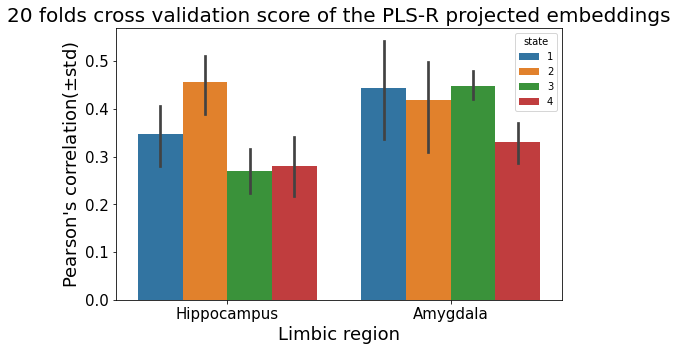

In [86]:
plt.figure(figsize=(8,5))
sns.barplot(x='Limbic', y = 'rho', hue='state', data=df_cv, )
plt.xlabel("Limbic region",fontsize=18)
plt.ylabel("Pearson's correlation($\pm$std)",fontsize=18)
plt.title("20 folds cross validation score of the PLS-R projected embeddings",fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
save_fig=1
if save_fig:
    plt.savefig('/Users/enningyang/Downloads/hmm_figs/sup_plsr.png',bbox_inches='tight',dpi=600)

In [50]:
df_cv.groupby(['Limbic', 'state']).agg({'rho':['mean','std']}).reset_index()

Limbic state       rho          
                          mean       std
0     Amygdala     1  0.443002  0.248712
1     Amygdala     2  0.419725  0.220944
2     Amygdala     3  0.448534  0.069974
3     Amygdala     4  0.329780  0.097385
4  Hippocampus     1  0.347501  0.146686
5  Hippocampus     2  0.455707  0.141158
6  Hippocampus     3  0.269559  0.115411
7  Hippocampus     4  0.281376  0.145943

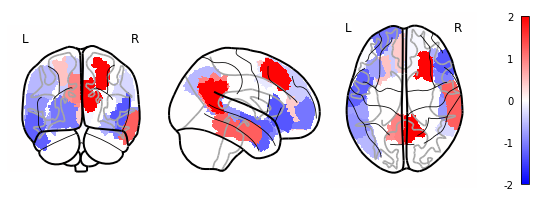

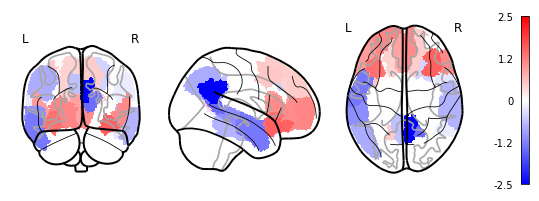

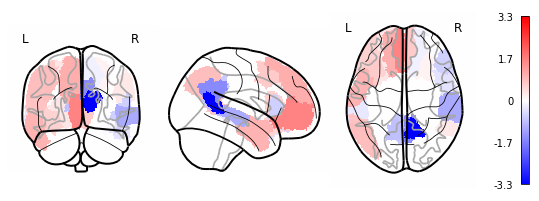

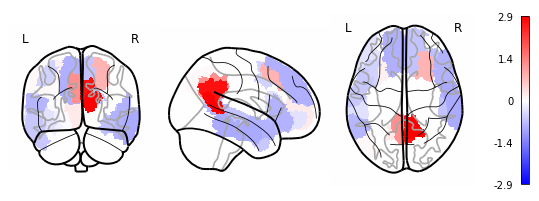

In [228]:
brains = []
for i in range(4):
    schaefer = nilearn.datasets.fetch_atlas_schaefer_2018(n_rois=100,
                                                yeo_networks=7)
    schaefer_rois = np.array(schaefer.labels, dtype=str)
    schaefer_atlas = schaefer.maps
    masker = NiftiLabelsMasker(labels_img=schaefer_atlas, standardize=False,
                                    memory='nilearn_cache').fit()
    data = np.zeros(100)
    data[dmn_idx] = zscore(y_loadings[i][:24]).reshape((-1))
    data = np.reshape(data, (-1, 1))
    nifti = masker.inverse_transform(data.T)
    brains.append(nifti)
    plotting.plot_glass_brain(nifti, threshold=None, colorbar=True,
                                  plot_abs=False, black_bg=False, cmap='bwr',
                                  symmetric_cbar=True, alpha=1)
    plt.show()

Text(32.09374999999999, 0.5, 'DN subregions')

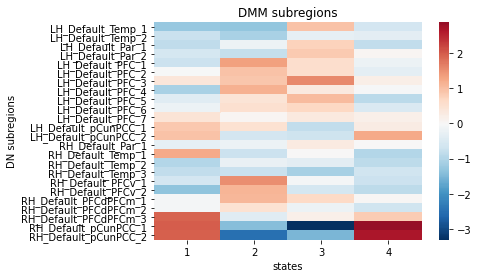

In [229]:
xticks = get_xticks(k)[:24]
dmn = []
for i in range(4):
    dmn.append(zscore(y_loadings[i][:24]))
dmn = np.hstack(dmn)

sns.heatmap(dmn, cmap='RdBu_r', center=0, yticklabels=xticks, xticklabels=range(1, 5))
plt.title('DMM subregions')
plt.xlabel('states')
plt.ylabel('DN subregions')

Text(32.99999999999999, 0.5, 'amygdala subregion')

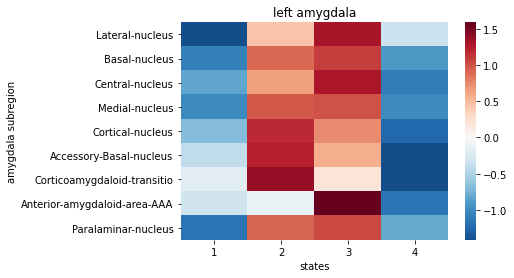

In [231]:
extra_loadings = zscore(np.array(y_loadings)[...,0][:,24:])
haNames = list(np.load(f'{tmp_dir}/hippoAmygNames.npy'))
hippoNames = haNames[19:]
sns.heatmap(extra_loadings[:,:9].T, cmap='RdBu_r', center=0, yticklabels=hippoNames, xticklabels=range(1, 5))
plt.title('left amygdala')
plt.xlabel('states')
plt.ylabel('amygdala subregion')

Text(32.99999999999999, 0.5, 'amygdala subregion')

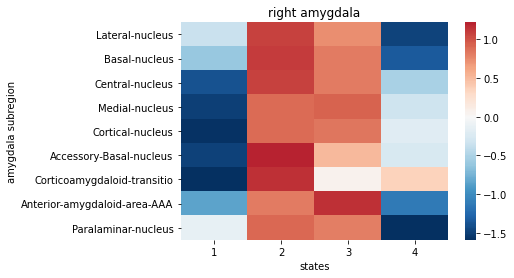

In [232]:
haNames = list(np.load(f'{tmp_dir}/hippoAmygNames.npy'))
hippoNames = haNames[19:]
sns.heatmap(extra_loadings[:,9:].T, cmap='RdBu_r', center=0, yticklabels=hippoNames, xticklabels=range(1, 5))
plt.title('right amygdala')
plt.xlabel('states')
plt.ylabel('amygdala subregion')

In [233]:
left_data = extra_loadings[:,:9]
right_data = extra_loadings[:,9:]
amygName_short = np.load(f'{tmp_dir}/amygName_short.npy')
tight = go.layout.Margin(
        l=0, #left margin
        r=0, #right margin
        b=0, #bottom margin
        t=0, #top margin
    )
categories = amygName_short
layout = go.Layout(
  margin=go.layout.Margin(
        l=0, #left margin
        r=0, #right margin
        b=0, #bottom margin
        t=0, #top margin
    )
)
fig = make_subplots(rows=4, cols=2,specs=[[{'type': 'polar'}]*2]*4,
                    row_titles=['State1','State2', 'State3','State4'],horizontal_spacing = 0,
                    vertical_spacing = 0.05)

for i in range(4):
    fig.add_trace(go.Scatterpolar(
          r=left_data[i].clip(min=0),
          theta=categories,
          fill='toself',fillcolor='orangered',line_color='red',dr=0.5,
          name='Pos',showlegend=not(i),opacity=0.7
    ),row=i+1,col=1)
    fig.add_trace(go.Scatterpolar(
          r=np.abs(left_data[i].clip(max=0)),
          theta=categories,
          fill='toself',fillcolor='lightblue',line_color='blue',dr=0.5,
          name='Neg',showlegend=not(i),opacity=0.7

    ),row=i+1,col=1)

    fig.add_trace(go.Scatterpolar(
          r=right_data[i].clip(min=0),
          theta=categories,
          fill='toself',fillcolor='orangered',line_color='red',dr=0.5,
          name='Pos',showlegend=False,opacity=0.7

    ),    row=i+1,col=2)
    fig.add_trace(go.Scatterpolar(
          r=np.abs(right_data[i].clip(max=0)),
          theta=categories,
          fill='toself',fillcolor='lightblue',line_color='blue',dr=0.5,
          name='Neg',showlegend=False,opacity=0.7
            ),row=i+1,col=2)


fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
    )),
  showlegend=True,
height=1200, width=800, margin=go.layout.Margin(
        l=0, #left margin
        r=0, #right margin
        b=0, #bottom margin
        t=50, #top margin
    ),title='Contribution of Each Subregion',title_x=0.5
    

)

In [152]:
x = np.array(x_loadings)[...,0]
emotion_idx = np.array(list(range(210,223)))
place_idx = np.array(range(223,244))
other_idx = np.hstack([list(range(200,210)),list(range(244,252))])
an_max = []
max_data = []
for i in [emotion_idx,place_idx,other_idx]:
    subset = np.array(annotations_keys)[i-200]
    subset_data = x[:,i]
    an_max.append([subset[k] for k in np.argmax(np.abs(x[:,i]),axis=1)])
    max_data.append([subset_data[j,k] for j,k in enumerate(np.argmax(np.abs(x[:,i]),axis=1))])

an_max = np.array(an_max)
max_data = np.vstack(max_data)
an_max.shape
an_max.T

array([['fear', 'Vietnam', 'val_neg'],
       ['love', 'Gump property', 'val_pos'],
       ['fear', 'New York', 'val_neg'],
       ['sadness', 'Washington D.C.', 'famous']], dtype='<U15')

In [153]:
max_data.T

array([[-0.09551957, -0.21151414, -0.13942483],
       [ 0.06602757,  0.23260627,  0.11957197],
       [-0.18823263, -0.13576209, -0.17274748],
       [-0.04943063, -0.25165588,  0.12892851]])

0.22168770888210024
0.2454113146445163
0.2008409018247065
0.26368762615256564


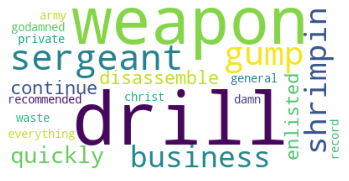

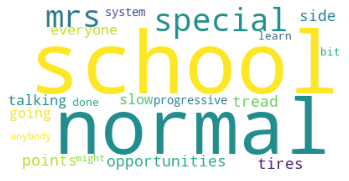

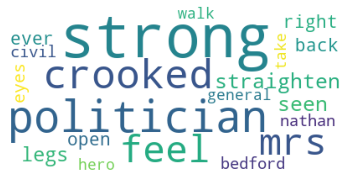

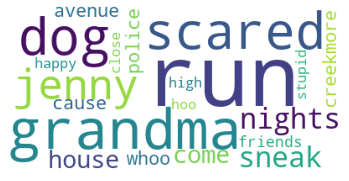

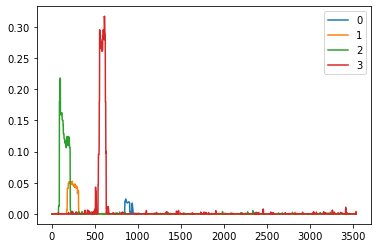

In [154]:
max_t = np.argmax(np.abs(x[:,:200]),axis=1)
for j, i in enumerate(max_t):
    plt.figure()
    print(x[j,i])
    image = img.imread("figs/text_components/{}of{}_{}_nmf.png".format(i, n_components, 'sub'))
    plt.axis('off')
    plt.imshow(image)
plt.figure()
for j, i in enumerate(max_t):
    sns.lineplot(x=range(3543),y=lsa_embed[:,i],label=j)
    

In [236]:
import plotly.figure_factory as ff

z = max_data.T[::-1,:]

xx = ['Emotion', 'Places', 'Others']
yy = ['State1', 'State2', 'State3','State4']
yy = yy[::-1]
z_text = an_max.T[::-1,:]
z_text = np.char.replace(z_text, ' ', '\n')
fig = ff.create_annotated_heatmap(np.abs(z), x=xx, y=yy, annotation_text=z_text, colorscale='viridis',showscale=True)
fig.update_layout(
    autosize=False,
    width=700,
    height=1000,
    font=dict(
        size=20
    )
#     paper_bgcolor="LightSteelBlue",
)
fig.update_traces(colorbar={'len':0.5})
fig.update_traces(colorbar_tickfont={'size':15})
for i in range(len(fig.layout.annotations)):
    fig.layout.annotations[i].font.size = 19
fig.show()